In [ ]:
import gdown
import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers
from keras import applications
from keras import optimizers
from keras.applications import EfficientNetB0
from keras.models import Model
from keras.metrics import Precision, Recall
from keras.callbacks import TensorBoard
from keras.utils import load_img, img_to_array
from keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Input
import matplotlib.pyplot as plt
import numpy as np

## Conseguir y preparar dataset

In [ ]:
# Dataset
poke_id = '1BQOodOsnStcMwdF1xIA41_i7tNNvRbYK'
poke_url = f'https://drive.google.com/uc?id={poke_id}'
gdown.download(poke_url, 'pokemondataset.zip', quiet = True)

'pokemondataset.zip'

In [ ]:
# Demonstration
demo_id = '1AEHHy1qQFASKTgQHofyHbFJmYCkPXGZr'
demo_url = f'https://drive.google.com/uc?id={demo_id}'
gdown.download(demo_url, 'demonstration.zip', quiet = True)

'demonstration.zip'

In [ ]:
!unzip 'pokemondataset.zip'
!rm -rf 'pokemondataset.zip'
!unzip 'demonstration.zip'
!rm -rf 'demonstration.zip'

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: pokemondataset/Vaporeon/ea7e7ba6ba604024b15cf37dc6802a02_jpg.rf.1b0c173b45ad96ba0f5df3883ece042d.jpg  
  inflating: pokemondataset/Vaporeon/ea7e7ba6ba604024b15cf37dc6802a02_jpg.rf.a709833fb01e40ce29e181091855acc9.jpg  
  inflating: pokemondataset/Vaporeon/ea7e7ba6ba604024b15cf37dc6802a02_jpg.rf.aabc4f26f98db083416841e0daf928af.jpg  
  inflating: pokemondataset/Vaporeon/ebac4de9ce1d449f99432f1e24f95041_jpg.rf.19cfbc27695ea3e860df77b6645fa245.jpg  
  inflating: pokemondataset/Vaporeon/ebac4de9ce1d449f99432f1e24f95041_jpg.rf.4b093d7bd34c54581be3144b50dab704.jpg  
  inflating: pokemondataset/Vaporeon/ebac4de9ce1d449f99432f1e24f95041_jpg.rf.53307cf024a0e3debadc0daab10294a0.jpg  
  inflating: pokemondataset/Vaporeon/ecef9aa233de4950bcf8901cfe16bd0c_jpg.rf.2d9b857c110e4e8316ccd2c1f74712dd.jpg  
  inflating: pokemondataset/Vaporeon/ecef9aa233de4950bcf8901cfe16bd0c_jpg.rf.ecbcd054db2eb80a09f5ab000371a3be.jpg  
  inflating

In [ ]:
DATASET_DIRECTORY = 'pokemondataset'
IMAGE_SIZE = (224,224)
BATCH_SIZE = 16
SHUFFLE = True
VALIDATION_SPLIT = 0.2

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIRECTORY,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    subset = 'training',
    validation_split = VALIDATION_SPLIT,
    seed = 123,
    shuffle = SHUFFLE
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIRECTORY,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    subset = 'validation',
    validation_split = VALIDATION_SPLIT,
    seed = 123,
    shuffle = False
)

Found 45036 files belonging to 151 classes.
Using 36029 files for training.
Found 45036 files belonging to 151 classes.
Using 9007 files for validation.


(16, 224, 224, 3)
(16, 151)


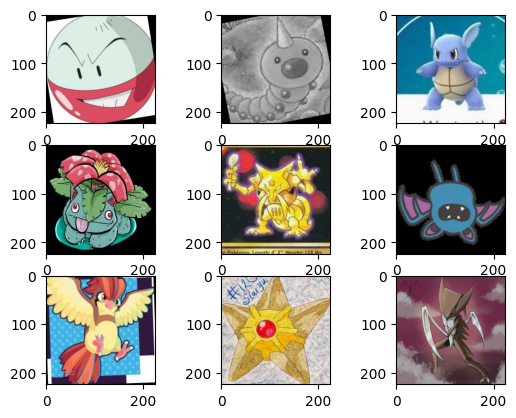

In [ ]:
from numpy import astype
for images, labels in train_ds.take(1):
  print(images.shape)
  print(labels.shape)

  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))

#VGG16

In [ ]:
import tensorflow as tf
from keras.applications import VGG16

IMG_SHAPE = IMAGE_SIZE + (3,)
inputs = layers.Input(shape=IMG_SHAPE)

# VGG16
base_model = VGG16(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

# Construcción de la cabeza del modelo
x = base_model(inputs, training=False)

x = GlobalMaxPooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
outputs = layers.Dense(151, activation='softmax')(x)

# Definición del Modelo
model_VGG16 = Model(inputs, outputs, name='Pokemon_VGG16')

model_VGG16.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=1e-4),
    metrics=[
        CategoricalAccuracy(name='acc'),
        TopKCategoricalAccuracy(k=3, name='top3')
    ]
)

model_VGG16.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "Pokemon_VGG16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 512)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 151)            │        77,463 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,054,807 (57.43 MB)

 Trainable params: 340,119 (1.30 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
history_VGG16 = model_VGG16.fit(
    train_ds,
    epochs=10,
    validation_data=validation_ds
)

Epoch 1/10
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 293s 125ms/step - acc: 0.0131 - loss: 25.3487 - top3: 0.0324 - val_acc: 0.0417 - val_loss: 4.8807 - val_top3: 0.1047
Epoch 2/10
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 267s 119ms/step - acc: 0.0259 - loss: 5.0283 - top3: 0.0526 - val_acc: 0.1009 - val_loss: 4.5798 - val_top3: 0.1721
Epoch 3/10
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 267s 118ms/step - acc: 0.0510 - loss: 4.8596 - top3: 0.0912 - val_acc: 0.1628 - val_loss: 4.1810 - val_top3: 0.2615
Epoch 4/10
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 322s 119ms/step - acc: 0.0888 - loss: 4.6086 - top3: 0.1457 - val_acc: 0.2239 - val_loss: 3.7906 - val_top3: 0.3269
Epoch 5/10
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 267s 118ms/step - acc: 0.1291 - loss: 4.3214 - top3: 0.2077 - val_acc: 0.3257 - val_loss: 3.2143 - val_top3: 0.4493
Epoch 6/10
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 267s 118ms/step - acc: 0.1779 - loss: 3.9767 - top3: 0.2757 - val_acc: 0.4148 - val_loss: 2.7508 - val_top3: 0.5438
Epoch 7/10
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 266s 118m

#EfficientNetB0

In [ ]:
# Definir la entrada
inputs = Input(shape=IMG_SHAPE)

base_model = EfficientNetB0(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

# Congelar el modelo
base_model.trainable = False

x = base_model(inputs, training=False)
x = GlobalMaxPooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(151, activation='softmax')(x)

model_EfficientNetB0 =  tf.keras.Model(inputs, x, name='EfficientNetB0')

model_EfficientNetB0.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=[
        CategoricalAccuracy(name='acc'),
        TopKCategoricalAccuracy(k=3, name='top3')
    ]
)

print(model_EfficientNetB0.summary())

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "EfficientNetB0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_1          │ (None, 1280)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 151)            │       193,431 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,243,002 (16.19 MB)

 Trainable params: 193,431 (755.59 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

None


In [ ]:
history_EfficientNetB0 = model_EfficientNetB0.fit(
    train_ds,
    epochs=10,
    validation_data=validation_ds
)

Epoch 1/10
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 116s 40ms/step - acc: 0.0572 - loss: 9.0192 - top3: 0.1154 - val_acc: 0.5969 - val_loss: 1.7590 - val_top3: 0.7523
Epoch 2/10
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 59s 26ms/step - acc: 0.3469 - loss: 3.6970 - top3: 0.5234 - val_acc: 0.7540 - val_loss: 1.0502 - val_top3: 0.8627
Epoch 3/10
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 60s 26ms/step - acc: 0.5268 - loss: 2.4049 - top3: 0.6951 - val_acc: 0.8210 - val_loss: 0.7699 - val_top3: 0.9064
Epoch 4/10
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 69s 30ms/step - acc: 0.6212 - loss: 1.8103 - top3: 0.7796 - val_acc: 0.8532 - val_loss: 0.6067 - val_top3: 0.9258
Epoch 5/10
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 59s 26ms/step - acc: 0.6818 - loss: 1.4693 - top3: 0.8233 - val_acc: 0.8775 - val_loss: 0.5134 - val_top3: 0.9409
Epoch 6/10
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 59s 26ms/step - acc: 0.7163 - loss: 1.2417 - top3: 0.8515 - val_acc: 0.8994 - val_loss: 0.4105 - val_top3: 0.9561
Epoch 7/10
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 84s 27ms/step - acc: 

#EfficientNetB0 - Fine Tuning

In [ ]:
from keras.applications import EfficientNetB0
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input


IMG_SHAPE = IMAGE_SIZE + (3,)

# Definir la entrada
inputs = Input(shape=IMG_SHAPE)

# Cargar el modelo base
base_model = EfficientNetB0(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

# Congelar el modelo
base_model.trainable = False

x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(151, activation='softmax')(x)

model_FineTuning = tf.keras.Model(inputs, outputs, name="Pokemon_Classifier")

# Compilación del modelo
model_FineTuning.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=[
        CategoricalAccuracy(name='acc'),
        TopKCategoricalAccuracy(k=3, name='top3')
    ]
)

print(model_FineTuning.summary())

Model: "Pokemon_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 151)            │       193,431 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,243,002 (16.19 MB)

 Trainable params: 193,431 (755.59 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

None


In [ ]:
EPOCHS = 5

history_FineTuning = model_FineTuning.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=validation_ds
)

Epoch 1/5
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 99s 35ms/step - acc: 0.5203 - loss: 2.4386 - top3: 0.6466 - val_acc: 0.8995 - val_loss: 0.5322 - val_top3: 0.9563
Epoch 2/5
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 60s 26ms/step - acc: 0.8472 - loss: 0.6625 - top3: 0.9360 - val_acc: 0.9379 - val_loss: 0.3213 - val_top3: 0.9778
Epoch 3/5
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 59s 26ms/step - acc: 0.8875 - loss: 0.4645 - top3: 0.9601 - val_acc: 0.9594 - val_loss: 0.2146 - val_top3: 0.9877
Epoch 4/5
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 58s 26ms/step - acc: 0.9061 - loss: 0.3679 - top3: 0.9723 - val_acc: 0.9677 - val_loss: 0.1654 - val_top3: 0.9906
Epoch 5/5
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 58s 26ms/step - acc: 0.9173 - loss: 0.3130 - top3: 0.9791 - val_acc: 0.9747 - val_loss: 0.1348 - val_top3: 0.9926


In [ ]:
# Descongelar el modelo base
base_model.trainable = True

# Congelar todas las capas excepto las últimas ~30
# Esto deja la mayoría de los pesos de ImageNet intactos pero permite ajustes finos en las capas de características más altas.
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompilar el modelo
model_FineTuning.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy',
      TopKCategoricalAccuracy(k=3, name='top3')]
)

print(model_FineTuning.summary())

FINE_TUNE_EPOCHS = 5
TOTAL_EPOCHS = EPOCHS + FINE_TUNE_EPOCHS

history_Final = model_FineTuning.fit(
    train_ds,
    epochs=TOTAL_EPOCHS,
    initial_epoch=history_FineTuning.epoch[-1],
    validation_data=validation_ds
)

Model: "Pokemon_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 151)            │       193,431 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,243,002 (16.19 MB)

 Trainable params: 1,689,591 (6.45 MB)

 Non-trainable params: 2,553,411 (9.74 MB)

None
Epoch 5/10
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 122s 42ms/step - accuracy: 0.8035 - loss: 0.7701 - top3: 0.9166 - val_accuracy: 0.9550 - val_loss: 0.2313 - val_top3: 0.9856
Epoch 6/10
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 102s 31ms/step - accuracy: 0.8870 - loss: 0.4459 - top3: 0.9627 - val_accuracy: 0.9710 - val_loss: 0.1516 - val_top3: 0.9902
Epoch 7/10
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 70s 31ms/step - accuracy: 0.9106 - loss: 0.3513 - top3: 0.9733 - val_accuracy: 0.9767 - val_loss: 0.1160 - val_top3: 0.9928
Epoch 8/10
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 70s 31ms/step - accuracy: 0.9271 - loss: 0.2913 - top3: 0.9801 - val_accuracy: 0.9813 - val_loss: 0.0946 - val_top3: 0.9947
Epoch 9/10
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 70s 31ms/step - accuracy: 0.9322 - loss: 0.2589 - top3: 0.9829 - val_accuracy: 0.9837 - val_loss: 0.0803 - val_top3: 0.9949
Epoch 10/10
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 70s 31ms/step - accuracy: 0.9426 - loss: 0.2285 - top3: 0.9861 - val_accuracy: 0.9856 - val_loss: 0.0702 - val_top3: 0.9

#Mejora


In [ ]:
from keras.applications import EfficientNetB0
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input


IMG_SHAPE = IMAGE_SIZE + (3,)

# Definir la entrada
inputs = Input(shape=IMG_SHAPE)

# Cargar el modelo base
base_model = EfficientNetB0(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

# Congelar el modelo
base_model.trainable = False

x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='swish')(x)
x = Dropout(0.4)(x)
outputs = Dense(151, activation='softmax')(x)

model_FineTuning2 = tf.keras.Model(inputs, outputs, name="Pokemon_Classifier")

# Compilación del modelo
model_FineTuning2.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=[
        CategoricalAccuracy(name='acc'),
        TopKCategoricalAccuracy(k=3, name='top3')
    ]
)

print(model_FineTuning2.summary())

Model: "Pokemon_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 151)            │        77,463 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,782,906 (18.25 MB)

 Trainable params: 733,335 (2.80 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

None


In [ ]:
EPOCHS = 5

history_FineTuning2 = model_FineTuning2.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=validation_ds
)

Epoch 1/5
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 106s 38ms/step - acc: 0.5222 - loss: 2.1418 - top3: 0.6660 - val_acc: 0.9056 - val_loss: 0.3673 - val_top3: 0.9664
Epoch 2/5
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 63s 28ms/step - acc: 0.8264 - loss: 0.6322 - top3: 0.9315 - val_acc: 0.9301 - val_loss: 0.2536 - val_top3: 0.9820
Epoch 3/5
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 61s 27ms/step - acc: 0.8667 - loss: 0.4632 - top3: 0.9582 - val_acc: 0.9678 - val_loss: 0.1289 - val_top3: 0.9920
Epoch 4/5
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 61s 27ms/step - acc: 0.8882 - loss: 0.3760 - top3: 0.9697 - val_acc: 0.9615 - val_loss: 0.1463 - val_top3: 0.9905
Epoch 5/5
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 61s 27ms/step - acc: 0.8998 - loss: 0.3307 - top3: 0.9754 - val_acc: 0.9720 - val_loss: 0.1140 - val_top3: 0.9928


In [ ]:
# Descongelar el modelo base
base_model.trainable = True

# Congelar todas las capas excepto las últimas
# Esto deja la mayoría de los pesos de ImageNet intactos pero permite ajustes finos en las capas de características más altas.
for layer in base_model.layers[:-40]:
    layer.trainable = False

# Recompilar el modelo
model_FineTuning2.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss = 'categorical_crossentropy',
    metrics=[
        CategoricalAccuracy(name='acc'),
        TopKCategoricalAccuracy(k=3, name='top3')
    ]
)

print(model_FineTuning2.summary())

FINE_TUNE_EPOCHS = 5
TOTAL_EPOCHS = EPOCHS + FINE_TUNE_EPOCHS

history_Final2 = model_FineTuning2.fit(
    train_ds,
    epochs=TOTAL_EPOCHS,
    initial_epoch=history_FineTuning2.epoch[-1],
    validation_data=validation_ds
)

Model: "Pokemon_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 151)            │        77,463 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,782,906 (18.25 MB)

 Trainable params: 2,784,039 (10.62 MB)

 Non-trainable params: 1,998,867 (7.63 MB)

None
Epoch 5/10
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 130s 45ms/step - acc: 0.7675 - loss: 0.9562 - top3: 0.9001 - val_acc: 0.9593 - val_loss: 0.1525 - val_top3: 0.9872
Epoch 6/10
 529/2252 ━━━━━━━━━━━━━━━━━━━━ 50s 29ms/step - acc: 0.8594 - loss: 0.5027 - top3: 0.9539

#Pruebas


In [ ]:
!mkdir models

In [ ]:
model_VGG16.save('./models/pokemon_vgg16.keras')

In [ ]:
model_EfficientNetB0.save('./models/pokemon_efficientnetb0.keras')

In [ ]:
model_FineTuning.save('./models/pokemon_finetuning.keras')

In [ ]:
model_FineTuning2.save('./models/pokemon_finetuning2.keras')

In [ ]:
IMAGES_DIRECTORY = 'demonstration'
IMAGE_SIZE = (224,224)
BATCH_SIZE = 16

self_ds = tf.keras.utils.image_dataset_from_directory(
    IMAGES_DIRECTORY,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    seed = 123,
    crop_to_aspect_ratio=True,
)

Found 20 files belonging to 10 classes.


Loading models from: ./models/
Successfully loaded model: pokemon_finetuning2
Finished loading 1 models.

Processing images for class: Gengar


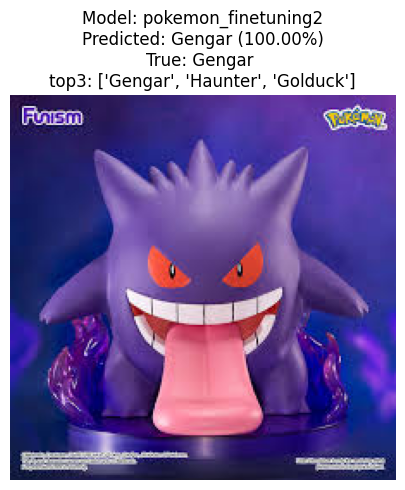

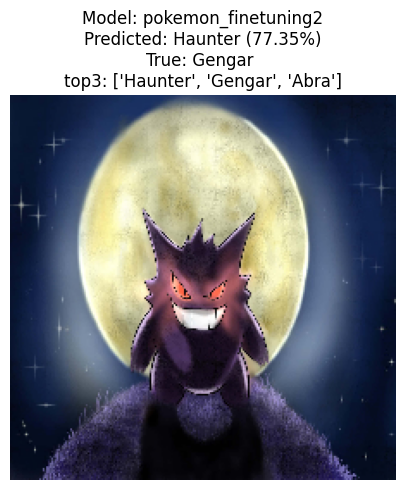


Processing images for class: Kabutops


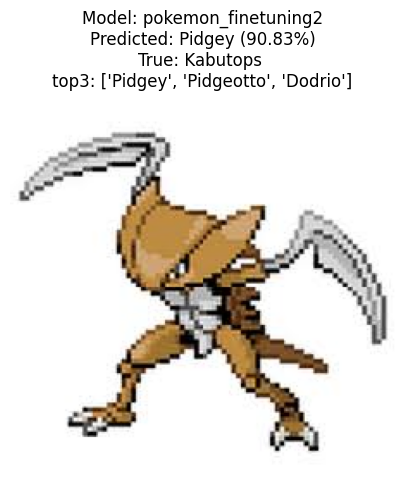

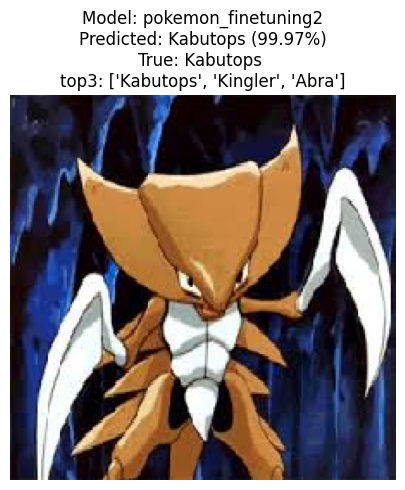


Processing images for class: Nidoking


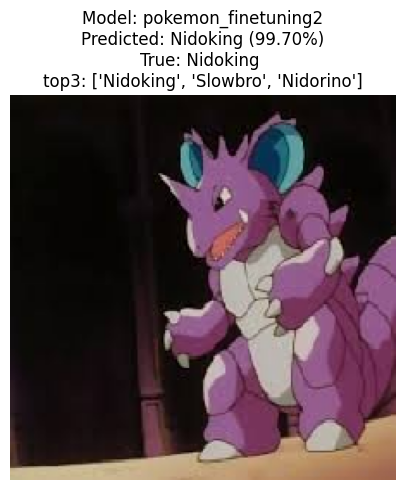

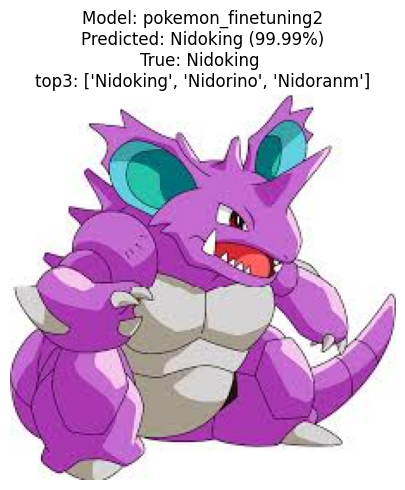


Processing images for class: Pidgeot


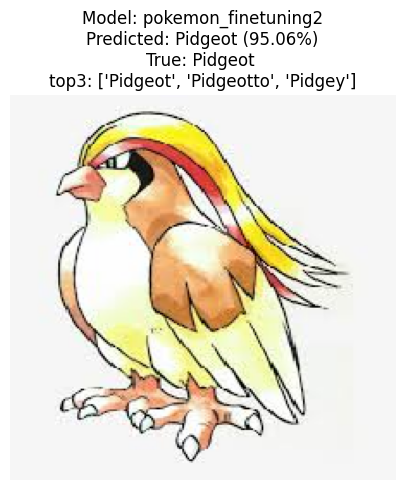

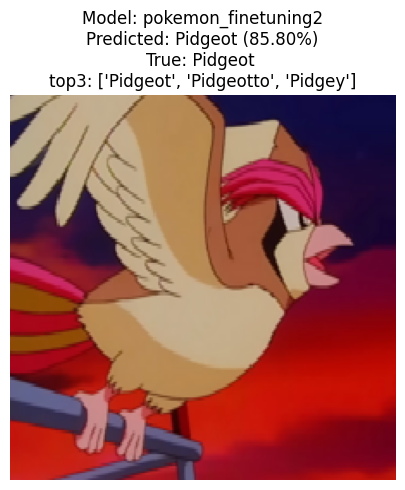


Processing images for class: Exeggutor


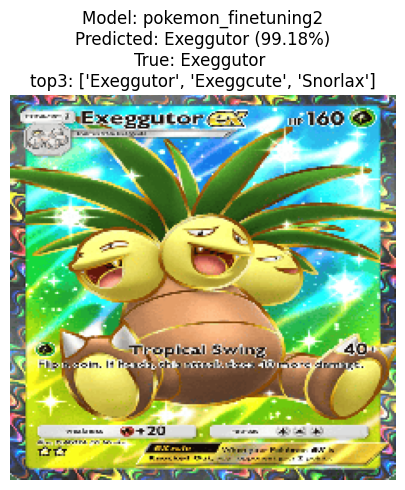

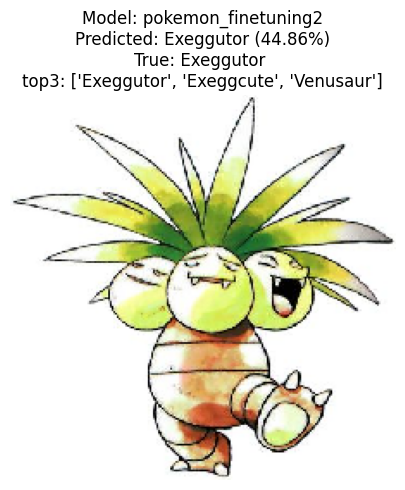


Processing images for class: Machamp


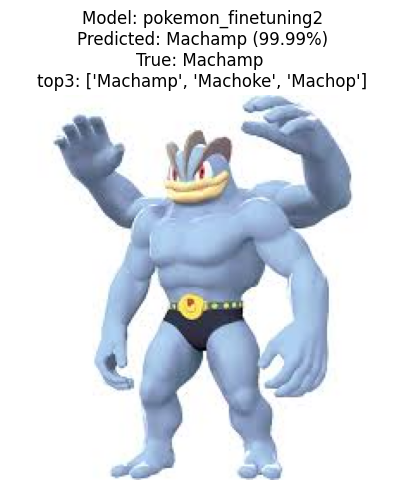

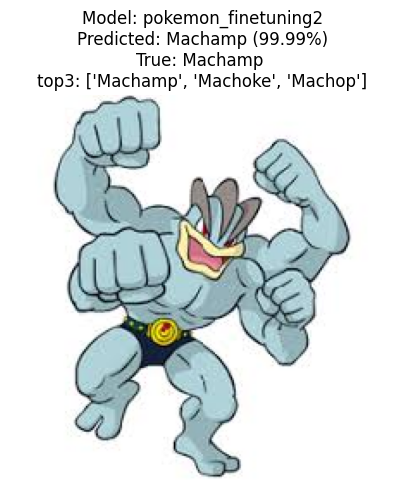


Processing images for class: Alakazam


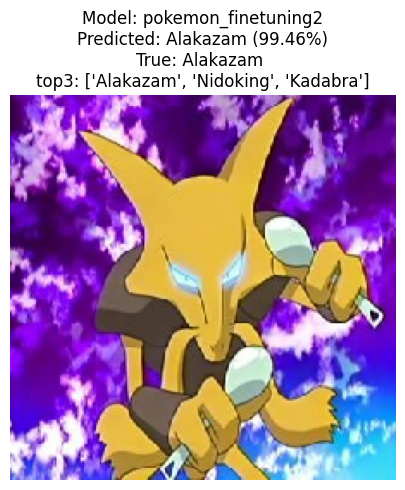

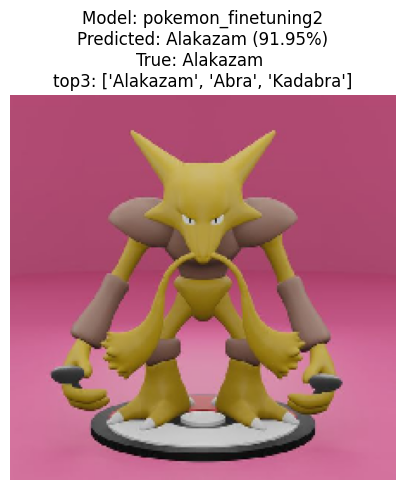


Processing images for class: Arcanine


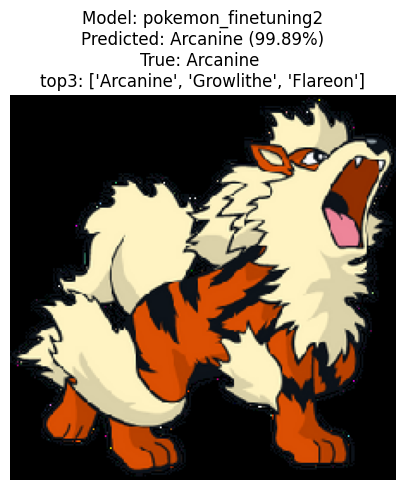

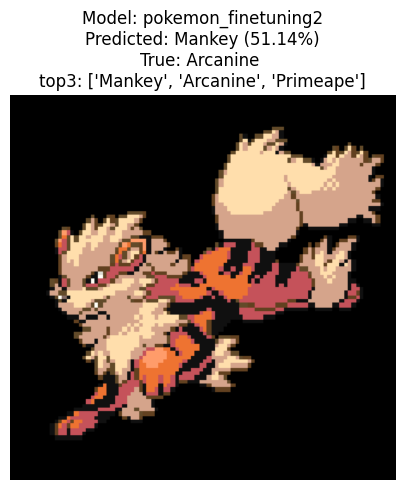


Processing images for class: Lapras


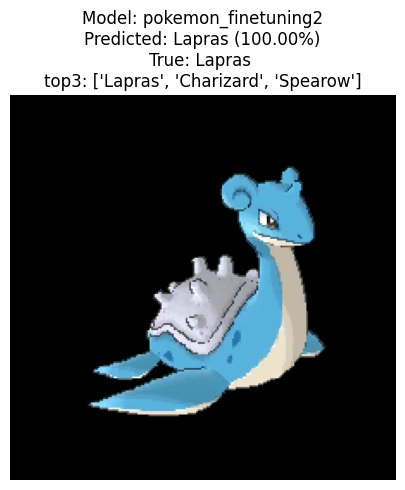

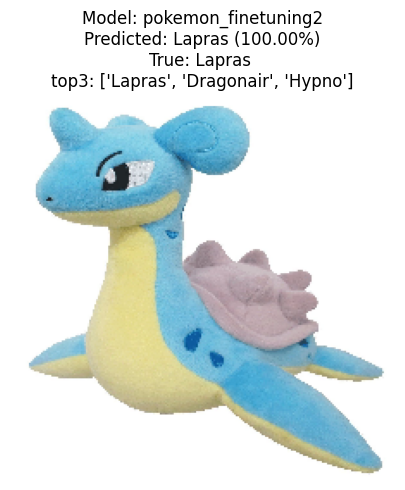


Processing images for class: Jolteon


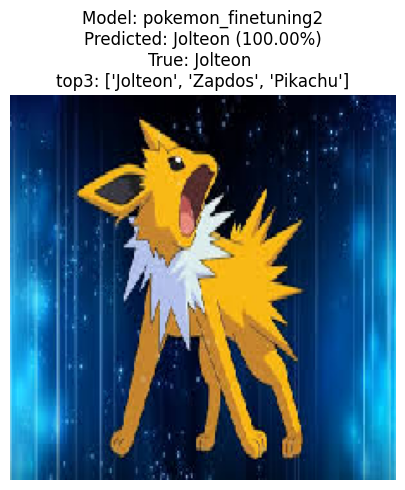

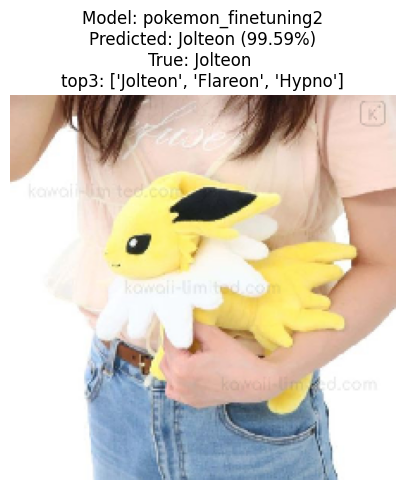

In [ ]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

class_names = train_ds.class_names

def run_all_model_predictions_on_images(images_directory, models_directory, class_names, img_size=(224,224)):

    # Cargar modelos
    loaded_models = {}
    for model_filename in os.listdir(models_directory):
        if model_filename.endswith('.keras'):
            model_path = os.path.join(models_directory, model_filename)
            try:
                model_name = os.path.splitext(model_filename)[0]
                loaded_models[model_name] = tf.keras.models.load_model(model_path)
            except Exception as e:
                print(f"Error loading model {model_filename}: {e}")
    if not loaded_models:
        print("No hay modelos")
        return

    for class_folder in os.listdir(images_directory):
        class_folder_path = os.path.join(images_directory, class_folder)
        if os.path.isdir(class_folder_path):
            true_label = class_folder

            # Cargar imagenes
            for image_file in os.listdir(class_folder_path):
                if image_file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                    img_path = os.path.join(class_folder_path, image_file)
                    img = load_img(img_path, target_size=img_size)
                    img_array = img_to_array(img)
                    img_array = np.expand_dims(img_array, axis=0)

                    num_models = len(loaded_models)
                    fig, axes = plt.subplots(1, num_models, figsize=(5 * num_models, 5))

                    if num_models == 1:
                        axes = [axes]

                    # Usar modelos
                    for i, (model_name, current_model) in enumerate(loaded_models.items()):
                        predictions = current_model.predict(img_array, verbose=0)
                        predicted_class_index = np.argmax(predictions[0])
                        predicted_class_name = class_names[predicted_class_index]
                        confidence = 100 * np.max(predictions[0])
                        top_k_indices = np.argsort(predictions[0])[-3:][::-1]
                        top_k_classes = [class_names[i] for i in top_k_indices]

                        ax = axes[i]
                        ax.imshow(img)
                        ax.axis("off")
                        ax.set_title(f"Model: {model_name}\nPredicted: {predicted_class_name} ({confidence:.2f}%)\nTrue: {true_label} \ntop3: {top_k_classes}")

                    plt.tight_layout()
                    plt.show()

run_all_model_predictions_on_images(IMAGES_DIRECTORY, './models/', class_names, IMAGE_SIZE)
